# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

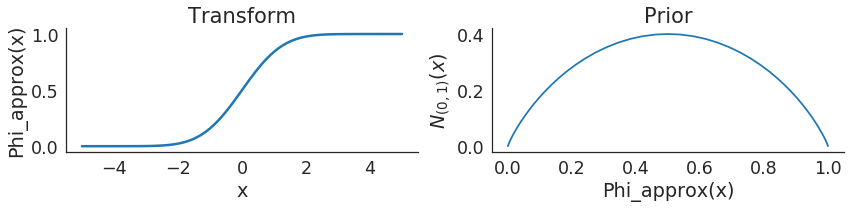

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

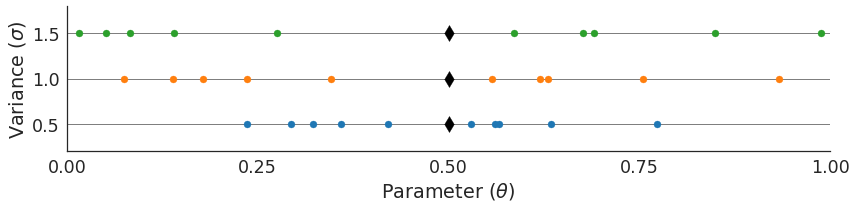

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prior on the mood-bias parameter ($f$) 

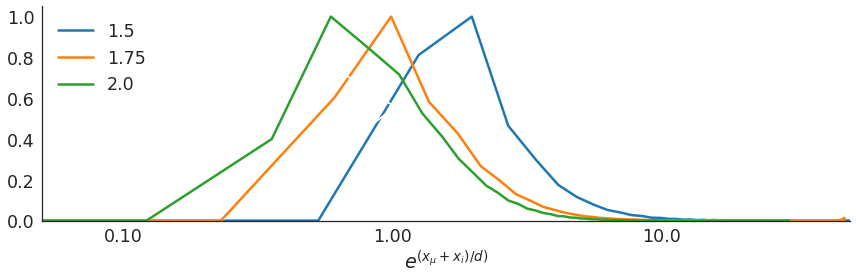

In [3]:
np.random.seed(47404)

## Simulate data.
f_pr = np.random.multivariate_normal(np.zeros(2), np.identity(2), int(1e6))
divisor = [1.5, 1.75, 2.0]

fig, ax = plt.subplots(1,1,figsize=(12,4))
for d in divisor:
    
    ## Compute f (assumings sigma = 1).
    f = np.exp( np.sum(f_pr, axis=1) / d )
    
    ## Plot.
    sns.kdeplot(f, color='w', ax=ax)
    line = ax.lines[-1]
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.plot(xdata, ydata/ydata.max(), lw=2.5, label=d)
    
ax.set_xscale('log')
ax.set(xlim=(0.05, 50), xticks=np.logspace(-1,2,4), xlabel=r'$e^{(x_\mu + x_i)/d)}$', 
       ylim=(0,1.05), xticklabels=['0.10','1.00','10.0','100.'])
ax.legend(loc=2)
sns.despine()
plt.tight_layout()

## Section 2: Model fitting

In [4]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare task data.
X = data[['M1','M2']].values.reshape(N,B,T,2)
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Define control parameters.
    if 'orig' in model_name: control = dict(adapt_delta = 0.9)
    else: control = None
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, 
                      chains=chains, control=control, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

<IPython.core.display.Javascript object>

## Posterior predictive check
Drawing inspiration from [Gelman (2000)](http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf)

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/numpy/lib/shape_base.py:243: RuntimeWarning: Mean of empty slice
  res = func(*args)


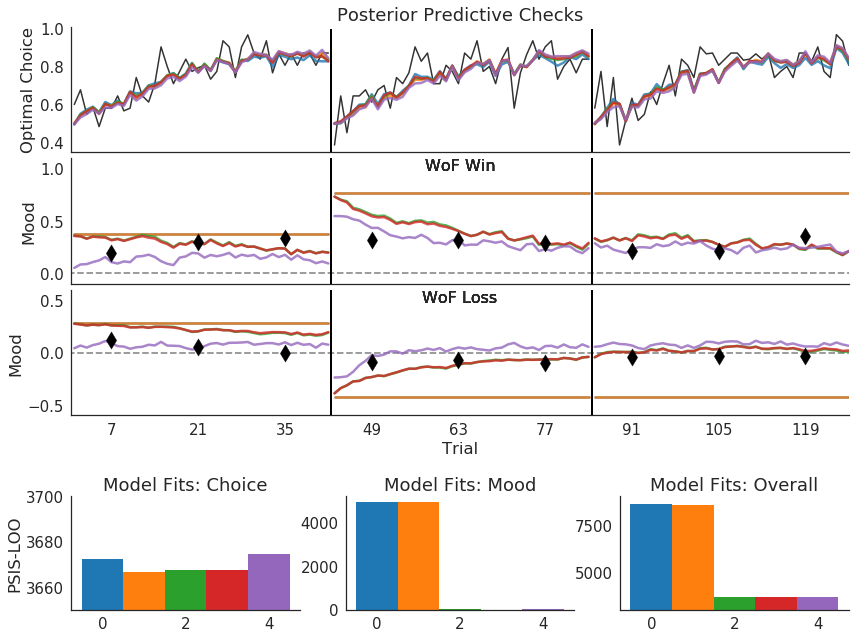

In [5]:
from scripts.psis import psisloo

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define Stan models.
model_names = ['moodRL_npool_base.stan', 
               'moodRL_ppool_base.stan',
               'moodRL_ppool_mood.stan',
               'moodRL_ppool_mood_bias_mod.stan',
               'moodRL_ppool_mood_bias_orig.stan'
              ]
  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,9))
sns.set_context('notebook', font_scale=1.5)
colors = sns.color_palette(n_colors=len(model_names))

## Customize axes with GridSpec.
gs = gridspec.GridSpec(3, 1)
gs.update(left=0.05, right=0.95, bottom=0.35,  top=0.95, hspace=0.05)
ax1, ax2, ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]),  plt.subplot(gs[2])

gs = gridspec.GridSpec(1, 3)
gs.update(left=0.05, right=0.95, bottom=0.05,  top=0.225, hspace=0)
ax4, ax5, ax6 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

for i, model_name in enumerate(model_names):
    
    ## Load StanFit file.
    f = 'stan_fits/%s/StanFit.pickle' %model_name.replace('.stan','')
    with open(f, 'rb') as f: extract = cPickle.load(f)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot group-level performance.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract data and compute optimal choice.
    optimal_choice = np.argmax(extract['X'], axis=-1)
    Y_obs = np.equal(extract['Y']-1, optimal_choice).astype(int)
    Y_pred = np.array([np.equal(sample, optimal_choice) for sample in extract['Y_pred']-1]).astype(int)
    
    ## Mask missing data.
    missing = extract['Y'] < 0
    Y_obs = np.where(missing, np.nan, Y_obs)
    Y_pred = np.array([np.where(missing, np.nan, sample) for sample in Y_pred])
    
    ## Compute average over subjects.
    Y_obs = np.nanmean(Y_obs, axis=0)
    Y_pred = np.apply_over_axes(np.nanmean, Y_pred, [0,1]).squeeze()
    n_blocks, n_trials = Y_obs.shape
    
    for block in np.arange(n_blocks):
        
        ## Define trial numbers.
        trials = np.arange(n_trials) + block * n_trials
        trials += 1
        
        ## Plot.
        if not i: ax1.plot( trials, Y_obs[block], lw=1.5, color='k', alpha=0.8 )
        ax1.plot( trials, Y_pred[block], lw=2.5, color=colors[i], alpha=0.8 )
        
    ## Add info.
    ax1.vlines([42.5, 84.5], 0, 1, lw=1.5, color='k', zorder=10)
    ax1.set(xlim=(0.5, 126), xticks=[], xlabel='', ylim=(0.35, 1.01), 
            ylabel='Optimal Choice', title='Posterior Predictive Checks')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot group-level mood change.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract mood data.
    M_obs = extract['M']
    M_pred = np.tanh( np.median(extract['h_pred'], axis=0) )
    
    ## Compute average across subjects by WoF outcome.
    WoF = extract['WoF']
    M_obs = np.array([M_obs[np.sign(WoF) == v].mean(axis=0) for v in [1,-1]])
    M_pred = np.array([M_pred[np.sign(WoF) == v].mean(axis=0) for v in [1,-1]])
        
    for block in np.arange(n_blocks):
        
        ## Define trial numbers.
        trials = np.array([7,21,35]) + block * n_trials
        trials = np.arange(n_trials) + block * n_trials + 1
        
        for outcome, ax in enumerate([ax2, ax3]):
            
            if not i: ax.scatter(trials[[6,20,34]], M_obs[outcome, block], s=150,
                                 marker='d', color='k', zorder=10)
            ax.plot(trials, M_pred[outcome, block], lw=2.5, color=colors[i], alpha=0.8)
    
    ## Add info.
    for ax, ylim, title in zip([ax2,ax3], [(-0.1, 1.1), (-0.6,0.6)], ['WoF Win', 'WoF Loss']):
        ax.vlines([42.5, 84.5], -3, 3, lw=1.5, color='k', zorder=10)
        ax.hlines(0, 0, n_trials*n_blocks+1, linestyle='--', alpha=0.1, zorder=0)
        ax.set(xlim=(0.5,126), xticks=[], ylim=ylim, ylabel='Mood')
        ax.annotate(title, (0,0), (0.5,0.9), xycoords='axes fraction', ha='center', fontsize=16)
    ax.set(xticks=np.arange(7,126,14), xlabel='Trial')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot WAIC.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract log-likelihood values.
    Y_log_lik = extract['Y_log_lik']
    M_log_lik = extract['M_log_lik']
    n_samp, n_subj, n_block, n_trial = Y_log_lik.shape
    
    ## Reshape data.
    Y_log_lik = Y_log_lik.reshape(n_samp, n_subj*n_block*n_trial)
    M_log_lik = M_log_lik.reshape(n_samp, n_subj*n_block*3)
    
    ## Remove log-likelihoods corresponding to missing data.
    Y_log_lik = np.where(Y_log_lik, Y_log_lik, np.nan)
    missing = np.isnan(Y_log_lik).mean(axis=0) > 0
    Y_log_lik = Y_log_lik[:,~missing] 
    
    ## Compute PSIS-LOO.
    Y_loo, _, _ = psisloo(Y_log_lik)
    M_loo, _, _ = psisloo(M_log_lik)
    T_loo, _, _ = psisloo(np.concatenate([Y_log_lik, M_log_lik], axis=-1))
    
    ## Plot.
    ax4.bar(i, -2*Y_loo, 1, color=colors[i])
    ax4.set(ylim=(3650,3700), ylabel='PSIS-LOO', title='Model Fits: Choice')
    
    ax5.bar(i, -2*M_loo, 1, color=colors[i])
    ax5.set(title='Model Fits: Mood')
        
    ax6.bar(i, -2*T_loo, 1, color=colors[i])
    ax6.set(ylim=(3000),title='Model Fits: Overall')
        
sns.despine()

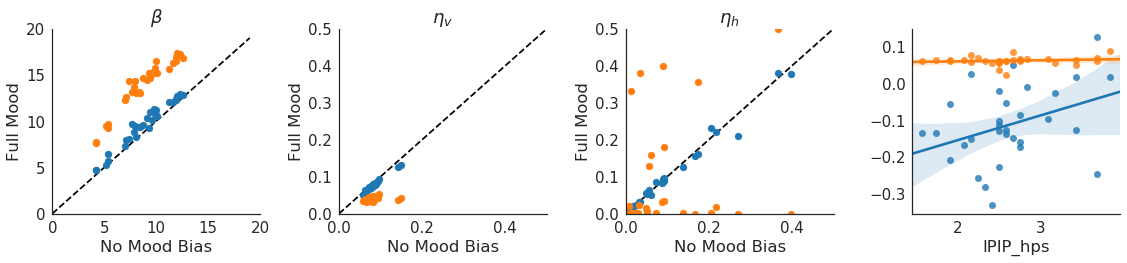

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

 ## Load mood StanFit file.
f = 'stan_fits/moodRL_ppool_mood/StanFit.pickle'
with open(f, 'rb') as f: fit1 = cPickle.load(f)
    
## Load mood bias (mod) StanFit file.
f = 'stan_fits/moodRL_ppool_mood_bias_mod/StanFit.pickle'
with open(f, 'rb') as f: fit2 = cPickle.load(f)
    
## Load mood bias (orig) StanFit file.
f = 'stan_fits/moodRL_ppool_mood_bias_orig/StanFit.pickle'
with open(f, 'rb') as f: fit3 = cPickle.load(f)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(16,4))

## Plot beta.
axes[0].scatter(np.median(fit1['beta'], axis=0), np.median(fit2['beta'], axis=0))
axes[0].scatter(np.median(fit1['beta'], axis=0), np.median(fit3['beta'], axis=0))
axes[0].plot(np.arange(20), np.arange(20), color='k', linestyle='--', zorder=0)
axes[0].set(xlim=(0,20), xlabel='No Mood Bias', ylim=(0,20), ylabel='Full Mood', title=r'$\beta$')

## Plot eta_v.
axes[1].scatter(np.median(fit1['eta_v'], axis=0), np.median(fit2['eta_v'], axis=0))
axes[1].scatter(np.median(fit1['eta_v'], axis=0), np.median(fit3['eta_v'], axis=0))
axes[1].plot(np.arange(2), np.arange(2), color='k', linestyle='--', zorder=0)
axes[1].set(xlim=(0,0.5), xlabel='No Mood Bias', ylim=(0,0.5), ylabel='Full Mood', title=r'$\eta_v$')
    
## Plot eta_h.
axes[2].scatter(np.median(fit1['eta_h'], axis=0), np.median(fit2['eta_h'], axis=0))
axes[2].scatter(np.median(fit1['eta_h'], axis=0), np.median(fit3['eta_h'], axis=0))
axes[2].plot(np.arange(2), np.arange(2), color='k', linestyle='--', zorder=0)
axes[2].set(xlim=(0,0.5), xlabel='No Mood Bias', ylim=(0,0.5), ylabel='Full Mood', title=r'$\eta_h$')
   
## Plot f.
sns.regplot(metadata.IPIP_hps, np.log10(np.median(fit2['f'], axis=0)), ax=axes[3])
sns.regplot(metadata.IPIP_hps, np.log10(np.median(fit3['f'], axis=0)), ax=axes[3])
# axes[3].plot([-0.5,0.5], [-0.5,0.5], color='k', linestyle='--', zorder=0)
# axes[3].set(xlim=(0,0.5), xlabel='No Mood Bias', ylim=(0,0.5), ylabel='Full Mood', title=r'$\eta_h$')
    
sns.despine()
plt.tight_layout()